#### Modern Wage Dynamics 
ASU Math+ ABM Spring School 2024 

J M Applegate  
February 14, 2024 
With price and wage set according to hours, and useable money and inventory.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})

In [2]:
#### initialisation_functions.py

import numpy as np

def create_firm(omega_0, p_0):
    I = 0
    pi = 0
    total_pi = 0
    omega = omega_0
    p = p_0
    H_D = 0
    S_P = 0
    S_S = 0
    return I, pi, total_pi, omega, p, H_D, S_P, S_S

def create_households(n, H_max, rng):
    alphas = rng.uniform(.1, .5, n)
    betas = 1 - alphas
    H_N = np.zeros(n)
    H_O = np.zeros(n)
    H = np.repeat(H_max / 2, n) #set intial household hours to half of H_max
    H_W = np.empty(n)
    income = np.empty(n)
    m = np.zeros(n)
    S = np.empty(n)
    S_C = np.empty(n)
    U = np.zeros(n)
    expenditure = np.zeros(n)
    return alphas, betas, H_N, H_O, H, H_W, income, m, S, S_C, U, expenditure

#vectorised implementation for intialisation
def optimal_demand(alpha, beta, omega, p, H_max, S_N):
    demand = beta * omega / p * H_max + alpha * S_N
    return demand

def initialise_demand_expectation(n, alpha, beta, omega, p, H_max, S_N, mu):
    demands = optimal_demand(alpha, beta, omega, p, H_max, S_N)
    #S_hat = n * np.average(demands)
    S_hat = np.sum(demands)
    memory = np.random.choice(demands, size = mu)#, replace = False)
    return S_hat, memory

In [3]:
#### firm functions

import numpy as np

def profit(omega, p, S_M, H_M):
    return p * S_M - omega * H_M

def determine_hours(S_D, A, gamma, S_N, n, I):
    if S_D >= n * S_N:
        planned = S_D
    else:
        planned = n * S_N
    # use inventory, could make hours demanded = 0
    if 0 < I < planned:
        planned -= I
    elif I >= planned:
        planned = 0
    H = (planned / A) ** ( 1 / gamma)
    return H

def produce_supply(A, N, gamma):
    return A * N ** gamma

def adjust_inventory(S_P, S_M, I):
    I += S_P - S_M
    return I

#### exponential decay
def decay(t, delta_0, theta, min_pct):
    return max(delta_0*np.exp(-1*theta*t), min_pct)

### WAGE AND PRICE UPDATE ALGORITHMS
### percentage change algorithms
### with pct set by decay function, simulated annealing
### with constant percent, fixed change
def update_wage_price(omega, p, H_S, H_D, S_S, S_D, pct):
    omega_new = omega
    if S_S > S_D:
        if H_S > H_D:
            p = p * (1 - pct)
        else:
            omega_new = omega_new * (1 - pct)
    elif S_S < S_D:
        if H_S > H_D:
            omega_new = omega_new * (1 + pct)
        else:
            p = p * (1 + pct)
    #### sticky wage
    #omega_new = omega
    return omega_new, p

def update_expectation(value, memory, mu):
    memory = np.append(memory[1:], value)
    weights = np.arange(1, mu + 1)
    hat = np.average(memory, weights = weights)
    # only use last observed value
    #hat = value
    return hat, memory

In [4]:
#### household_functions.py

import numpy as np

def tribute_hours(p, S_N, omega, m):
    #negative m increases tribute hours
    return np.maximum((p * S_N - m) / omega, 0)

def optional_hours(beta, alpha, H_max, omega, m, p, S_N):
    #only excess m to p*S_N counts in optional hours
    return max(0, beta * H_max - alpha / omega * (m - p * S_N))

def plan_consumption(S_N, omega, p, hours, m):
    income = hours * omega
    demand = np.maximum((income + m) / p, S_N)
    return demand, income

def calculate_utility(H_max, H_W, S_C, S_N, alpha, beta):
    return (H_max - H_W) ** alpha * (S_C - S_N) ** beta

def update_ledger(income, p, s, m):
    expenditure = p * s
    m += income - expenditure
    return m, expenditure

In [5]:
#### market_functions.py

import numpy as np

def aggregate_effort(H_S, H_D, H):
    if H_S > H_D:
        H_W = H_D / H_S * H
    else:
        H_W = H
    N = sum(H_W)
    return N, H_W

def sell_sugar(S_S, S_D, S):
    if S_S < S_D:
        S_C = S_S / S_D * S
    else:
        S_C = S
    return S_C

In [11]:
#### simulation.py

import numpy as np

#### import functions from model files
# from initialisation_functions import *
# from firm_functions import *
# from household_functions import *
# from market_functions import *

def simulation(r, s, t_max, n, H_max, omega_0, p_0, A, gamma, mu, S_N, delta_0, theta, min_pct, rng):
    sim_results = []
    t = 0
    pct_change = delta_0

    households = np.arange(0, n)

    #### intitialise firm and household
    I, pi, total_pi, omega, p, H_D, S_P, S_S = create_firm(omega_0, p_0)
    alphas, betas, H_N, H_O, H, H_W, income, m, S, S_C, U, expenditure = create_households(n, H_max, rng)
    N, S_D, H_M, S_M, H_S = 0, 0, 0, 0, 0

    #### initialise firm effort and demand expectations
    #idxs = rng.integers(0, n, size = mu)

    #### household sample S_hat
    #S_hat, demand_memory = initialise_demand_expectation(n, alpha[idxs], beta[idxs], omega, p, H_max, S_N)
    S_hat, demand_memory = initialise_demand_expectation(n, alphas, betas, omega, p, H_max, S_N, mu)

    #### save initial results
    step_results = [s, r, t, t_max, n, H_max, A, gamma, mu, S_N, omega_0, p_0, delta_0, theta, min_pct, pct_change,
                    I, pi, total_pi, omega, p, H_D, S_S, S_P, S_hat, N, H_S, H_M, S_D, S_M,
                    np.sum(H_N), np.sum(H_O), np.sum(m), np.median(m), np.mean(m), np.max(m), 
                    np.min(m), np.mean(U), np.mean(alphas)]
    sim_results.append(step_results)

    #### the simulation steps can be run for a fixed number, t_max, 
    #### or with the stopping condition that S_S is within 1 unit of S_D.

    #### conditional steps
    # while ((abs(S_S - S_D) >= 1 or abs(pi) >= 1) and t < t_max) or t == 0:
    #     #print('supply demand delta is', abs(S_S - S_D), 'and pi is', abs(pi))
    #     t = t + 1

    #### t_max simulation steps
    for t in range(1, t_max + 1):

        #### firm determines hours
        H_D = determine_hours(S_hat, A, gamma, S_N, n, I)

        #### households determine effort and hours supplied
        H_N = tribute_hours(p, S_N, omega, m)
        for h in range(n):
            H_O[h] = optional_hours(betas[h], alphas[h], H_max, omega, m[h], p, S_N)
        H = np.minimum(H_N + H_O, H_max)

        #### market aggregates hours supplied, determines market hours and effective effort
        H_S = np.sum(H)
        H_M = min(H_D, H_S)
        N, H_W = aggregate_effort(H_S, H_D, H)

        #### firm produces sugar with effective labour
        S_P = produce_supply(A, N, gamma)
        S_S = S_P + I

        #### households plan sugar consumption
        S, income = plan_consumption(S_N, omega, p, H_W, m)

        #### market aggregates sugar demand and determines sugar sold
        S_D = np.sum(S)
        S_M = min(S_S, S_D)
        S_C = sell_sugar(S_S, S_D, S)

        #### calculate firm profit
        pi = profit(omega, p, S_M, H_M)
        total_pi += pi

        #### calculate household utility
        U = calculate_utility(H_max, H_W, S_C, S_N, alphas, betas)

        #### households adjust ledgers
        m, expenditure = update_ledger(income, p, S_C, m)

        #### firm adjusts inventory
        I = adjust_inventory(S_P, S_M, I)

        #### firm updates demand expectations
        S_hat, demand_memory = update_expectation(S_D, demand_memory, mu)

        #### firm raises or lowers wage and price
        #pct_change = delta_0
        pct_change = decay(t, delta_0, theta, min_pct)
        omega, p = update_wage_price(omega, p, H_S, H_D, S_S, S_D, pct_change)
        min_H_D = (n * S_N / A) ** (1 / gamma)

        #### write step state to frame
        step_results = [s, r, t, t_max, n, H_max, A, gamma, mu, S_N, omega_0, p_0, delta_0, theta, min_pct, pct_change,
                        I, pi, total_pi, omega, p, H_D, S_S, S_P, S_hat, N, H_S, H_M, S_D, S_M,
                        np.sum(H_N), np.sum(H_O), np.sum(m), np.median(m), np.mean(m), np.max(m), 
                        np.min(m), np.mean(U), np.mean(alphas)]
        sim_results.append(step_results)

    return sim_results

In [12]:
#### series_parameters.py

def series_params():
    series_name = 'ABMSS2024_1'
    directory = './results/'

    #### series variables
    seed = None
    t_max = 500 #number of simulation steps
    reps = 100#repetitions of each parameter set

    #### simulation variables
    n_list = [100] #number of households
    omega_0_list = [10] #[1, 10, 15, 20, 25, 30] #inital wage
    p_0_list = [1] #intial price
    H_max = 400 #max household hours per month

    #### firm parameters
    A_list = [3] #firm production function coefficient
    gamma_list = [1.2] #firm production function exponent
    mu_list = [1] #memory for firm expectation updates

    #### base consumption requirement
    S_N_list = [1200] #[1200] #minimum household consumption

    #### simulated annealing control parameters
    delta_0_list = [.1] #coefficient of decay function
    theta_list = [.1] #exponent of decay function
    min_pct_list = [0]  #
 
    param_sets = [[n, omega_0, p_0, A, gamma, mu, S_N, delta_0, theta, min_pct] for n in n_list 
                    for omega_0 in omega_0_list for p_0 in p_0_list for A in A_list for 
                    gamma in gamma_list for mu in mu_list for S_N in S_N_list 
                    for delta_0 in delta_0_list for theta in theta_list for min_pct in min_pct_list]

    #### determine number of distinct parameter sets
    n_sets = len(param_sets)
    
    #### add fixed parameters
    #### resulting list is: s, t_max, n, H_max, omega_0, p_0, A, gamma, mu, S_N, delta_0, theta, min_pct
    for s in range(n_sets):
        (param_sets[s]).insert(0, t_max)
        (param_sets[s]).insert(2, H_max)
        (param_sets[s]).insert(0, s)

    #### include run number as 1st parameter for multithreading
    expanded_sets = [item.copy() for item in param_sets for i in range(reps)]
    run_list = list(range(reps)) * n_sets
    for i in range(n_sets * reps):
        (expanded_sets[i]).insert(0, run_list[i])

    return directory, series_name, seed, reps, n_sets, expanded_sets


In [13]:
# main.py

import numpy as np
import pandas as pd

#### import functions from model files
# from series_parameters import series_params
# from initialisation_functions import *
# from firm_functions import *
# from household_functions import *
# from market_functions import *
# from simulation import simulation

from numpy.random import default_rng
from operator import itemgetter

import warnings
warnings.filterwarnings('ignore')

#### series setup
directory, series_name, seed, reps, n_sets, series_params_list = series_params()

#### verify directory exists
from pathlib import Path
Path(directory).mkdir(parents=True, exist_ok=True)

#### initialise rng to be used by simulation series
rng = default_rng(seed)

print('This experiment consists of {} simulations'.format(n_sets * reps))
print('consisting of {} parameter sets.'.format(n_sets))

#### intitialise storage vehicle for series results
series_results = []

#### main body of multi parameter set code
for params in series_params_list:
    sim_results = simulation(*params, rng)
    series_results = series_results + sim_results

print('\nFinished series.')

macro_labels = ['set', 'run', 'step', 't_max', 'n', 'H_max', 'A', 'gamma', 'mu', 'S_N', 'omega_0', 'p_0', 'delta_0', 
                'theta', 'min_pct', 'pct_change',
                'I', 'pi', 'total_pi', 'omega', 'p', 'H_D', 'S_S', 'S_P', 'S_hat', 'N', 'H_S', 'H_M', 'S_D', 'S_M',
                'total_H_N', 'total_H_O','total_m', 'med_m', 'mean_m', 'max_m', 'min_m', 'mean_U', 'mean_alpha']

#### Transform list of lists into dataframes
series_results_frame = pd.DataFrame(series_results, columns = macro_labels)

#### For troubleshooting
#print(series_results_frame)

#### Save dataframe to directory as csv file.
# print('Writing to files.')
# prefix = directory + 'series_' + series_name
# series_results_frame.to_csv(prefix + '.csv', index = False)
# print('Series results written to', prefix + '.csv')


This experiment consists of 100 simulations
consisting of 1 parameter sets.

Finished series.


In [14]:
srf = series_results_frame
del(series_results_frame)
srf['mean_beta'] = 1 - srf['mean_alpha']
srf['ratio'] = srf['omega'] / srf['p']
srf['sugar_diff'] = abs(srf['S_S'] - srf['S_D'])
srf['hours_diff'] = abs(srf['S_S'] - srf['S_D'])
final_srf = srf[srf['step'] == max(srf['step'])]

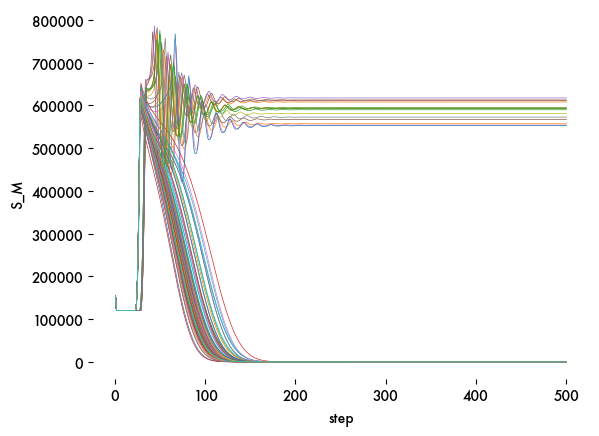

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})

plot_data = srf[['step', 'S_M', 'run']][srf['step'] > 0][srf['theta'] == .1]
plot_data_wide = pd.pivot_table(plot_data, index = ['step'], values = ['S_M'], columns = ['run'])
plot_data_wide.plot(linewidth=.5, legend=None)

plt.ylabel('S_M')
#plt.title('Household Simulation Results')
sns.despine(left = True, bottom = True)

In [17]:
plot = plot_data_wide.plot()
plt.close()
colours = plot.lines
colour_list = []
for r in range(100):
    colour_list.append(colours[r].get_color())

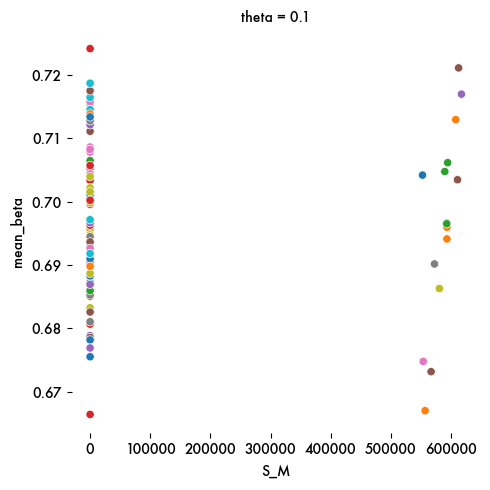

In [18]:
sns.relplot(
    data=final_srf,
    x="S_M", y="mean_beta",
    hue="run", col="theta",
    kind="scatter", 
    height=5, aspect=1, legend=None,
    palette = colour_list
)
sns.despine(left = True, bottom = True)
#plt.savefig('HoursAnnealingScanSingleHouseholdBetas.pdf')